In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Trasformazioni con data augmentation leggera
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

In [ ]:
# =============================================================================
# QUATERNION OPERATION
# =============================================================================

def quaternion_conv(q_input, q_weight, bias=None, stride=1, padding=0, dilation=1, groups=1):
    """
    Quaternion convolution operation
    q_input: [batch, 4*in_channels, height, width] - quaternion input (r,i,j,k)
    q_weight: [4*out_channels, in_channels, kernel_h, kernel_w] - quaternion weights
    """
    batch_size, in_ch_4, height, width = q_input.shape
    out_ch_4, in_ch, kernel_h, kernel_w = q_weight.shape
    
    in_channels = in_ch_4 // 4
    out_channels = out_ch_4 // 4
    
    # Split input into r, i, j, k components
    r_input = q_input[:, :in_channels]
    i_input = q_input[:, in_channels:2*in_channels]  
    j_input = q_input[:, 2*in_channels:3*in_channels]
    k_input = q_input[:, 3*in_channels:]
    
    # Split weights into r, i, j, k components
    r_weight = q_weight[:out_channels]
    i_weight = q_weight[out_channels:2*out_channels]
    j_weight = q_weight[2*out_channels:3*out_channels]
    k_weight = q_weight[3*out_channels:]
    
    # Quaternion multiplication: (a + bi + cj + dk)(e + fi + gj + hk)
    # Result = (ae - bf - cg - dh) + (af + be + ch - dg)i + (ag - bh + ce + df)j + (ah + bg - cf + de)k
    
    # Real part: ae - bf - cg - dh
    rr = F.conv2d(r_input, r_weight, None, stride, padding, dilation, groups)
    ii = F.conv2d(i_input, i_weight, None, stride, padding, dilation, groups)
    jj = F.conv2d(j_input, j_weight, None, stride, padding, dilation, groups)
    kk = F.conv2d(k_input, k_weight, None, stride, padding, dilation, groups)
    
    # i component: af + be + ch - dg  
    ri = F.conv2d(r_input, i_weight, None, stride, padding, dilation, groups)
    ir = F.conv2d(i_input, r_weight, None, stride, padding, dilation, groups)
    jk = F.conv2d(j_input, k_weight, None, stride, padding, dilation, groups)
    kj = F.conv2d(k_input, j_weight, None, stride, padding, dilation, groups)
    
    # j component: ag - bh + ce + df
    rj = F.conv2d(r_input, j_weight, None, stride, padding, dilation, groups)
    ik = F.conv2d(i_input, k_weight, None, stride, padding, dilation, groups)
    jr = F.conv2d(j_input, r_weight, None, stride, padding, dilation, groups)
    ki = F.conv2d(k_input, i_weight, None, stride, padding, dilation, groups)
    
    # k component: ah + bg - cf + de
    rk = F.conv2d(r_input, k_weight, None, stride, padding, dilation, groups)
    ij = F.conv2d(i_input, j_weight, None, stride, padding, dilation, groups)
    ji = F.conv2d(j_input, i_weight, None, stride, padding, dilation, groups)
    kr = F.conv2d(k_input, r_weight, None, stride, padding, dilation, groups)
    
    # Combine results
    output_r = rr - ii - jj - kk
    output_i = ri + ir + jk - kj
    output_j = rj - ik + jr + ki
    output_k = rk + ij - ji + kr
    
    # Add bias if provided
    if bias is not None:
        bias_r = bias[:out_channels].view(1, -1, 1, 1)
        bias_i = bias[out_channels:2*out_channels].view(1, -1, 1, 1)
        bias_j = bias[2*out_channels:3*out_channels].view(1, -1, 1, 1)
        bias_k = bias[3*out_channels:].view(1, -1, 1, 1)
        
        output_r += bias_r
        output_i += bias_i
        output_j += bias_j
        output_k += bias_k
    
    # Concatenate all components
    output = torch.cat([output_r, output_i, output_j, output_k], dim=1)
    return output

def quaternion_init(weight, gain=1.0):
    """
    Inizializza un tensor quaternion della stessa shape di weight.
    weight: [4*out_features, in_features] oppure [4*out_channels, in_channels, kh, kw]
    """
    shape = weight.shape
    if len(shape) == 2:  # Linear
        out_features_4, in_features = shape
        out_features = out_features_4 // 4
        v_r = torch.randn(out_features, in_features)
        v_i = torch.randn(out_features, in_features)
        v_j = torch.randn(out_features, in_features)
        v_k = torch.randn(out_features, in_features)
        # Normalizza
        norm = torch.sqrt(v_r**2 + v_i**2 + v_j**2 + v_k**2) + 1e-8
        v_r = gain * v_r / norm
        v_i = gain * v_i / norm
        v_j = gain * v_j / norm
        v_k = gain * v_k / norm
        # Concatenazione
        w = torch.cat([v_r, v_i, v_j, v_k], dim=0)
        return w
    elif len(shape) == 4:  # Conv
        out_channels_4, in_channels, kh, kw = shape
        out_channels = out_channels_4 // 4
        v_r = torch.randn(out_channels, in_channels, kh, kw)
        v_i = torch.randn(out_channels, in_channels, kh, kw)
        v_j = torch.randn(out_channels, in_channels, kh, kw)
        v_k = torch.randn(out_channels, in_channels, kh, kw)
        norm = torch.sqrt(v_r**2 + v_i**2 + v_j**2 + v_k**2) + 1e-8
        v_r = gain * v_r / norm
        v_i = gain * v_i / norm
        v_j = gain * v_j / norm
        v_k = gain * v_k / norm
        w = torch.cat([v_r, v_i, v_j, v_k], dim=0)
        return w

In [ ]:
# =============================================================================
# QUATERNION LAYERS
# =============================================================================

class QuaternionConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
                 padding=0, dilation=1, groups=1, bias=True):
        super(QuaternionConv2d, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        
        # Quaternion weights: [4*out_channels, in_channels, kernel_h, kernel_w]
        self.weight = nn.Parameter(torch.empty(4 * out_channels, in_channels, 
                                              self.kernel_size[0], self.kernel_size[1]))
        
        if bias:
            self.bias = nn.Parameter(torch.empty(4 * out_channels))
        else:
            self.register_parameter('bias', None)
            
        self.reset_parameters()
    
    def reset_parameters(self):
        # Initialize with quaternion initialization
        with torch.no_grad():
            self.weight.copy_(quaternion_init(self.weight))
        if self.bias is not None:
            nn.init.zeros_(self.bias)
    
    def forward(self, input):
        return quaternion_conv(input, self.weight, self.bias, self.stride, 
                             self.padding, self.dilation, self.groups)

class QuaternionLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(QuaternionLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Peso: 4*output x input (quaternioni gestiti internamente)
        self.weight = nn.Parameter(torch.empty(4 * out_features, in_features))
        
        if bias:
            self.bias = nn.Parameter(torch.empty(4 * out_features))
        else:
            self.register_parameter('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        with torch.no_grad():
            self.weight.copy_(quaternion_init(self.weight))
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, x):
        batch_size = x.shape[0]
        in_features = self.in_features
        out_features = self.out_features

        # Split input in quaternion components
        r_input = x[:, :in_features]
        i_input = x[:, in_features:2*in_features]
        j_input = x[:, 2*in_features:3*in_features]
        k_input = x[:, 3*in_features:]

        # Split weights
        r_weight = self.weight[:out_features, :]
        i_weight = self.weight[out_features:2*out_features, :]
        j_weight = self.weight[2*out_features:3*out_features, :]
        k_weight = self.weight[3*out_features:, :]

        # Moltiplicazione quaternion
        output_r = (torch.mm(r_input, r_weight.t()) - torch.mm(i_input, i_weight.t()) -
                    torch.mm(j_input, j_weight.t()) - torch.mm(k_input, k_weight.t()))
        
        output_i = (torch.mm(r_input, i_weight.t()) + torch.mm(i_input, r_weight.t()) +
                    torch.mm(j_input, k_weight.t()) - torch.mm(k_input, j_weight.t()))
        
        output_j = (torch.mm(r_input, j_weight.t()) - torch.mm(i_input, k_weight.t()) +
                    torch.mm(j_input, r_weight.t()) + torch.mm(k_input, i_weight.t()))
        
        output_k = (torch.mm(r_input, k_weight.t()) + torch.mm(i_input, j_weight.t()) -
                    torch.mm(j_input, i_weight.t()) + torch.mm(k_input, r_weight.t()))
        
        output = torch.cat([output_r, output_i, output_j, output_k], dim=1)

        if self.bias is not None:
            output += self.bias

        return output

In [ ]:
# =============================================================================
# QUATERNION ACTIVATION FUNCTIONS
# =============================================================================

def quaternion_relu(input):
    """Apply ReLU to each quaternion component"""
    return F.relu(input)

def quaternion_split_relu(input):
    """Alternative quaternion ReLU that preserves quaternion structure"""
    batch_size, channels = input.shape[0], input.shape[1] // 4
    
    # Split into components
    r, i, j, k = torch.split(input, channels, dim=1)
    
    # Apply ReLU only to real part, preserve imaginary parts
    r_out = F.relu(r)
    
    return torch.cat([r_out, i, j, k], dim=1)

In [ ]:
# =============================================================================
# QUATERNION CNN MODEL
# =============================================================================

class QuaternionCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(QuaternionCNN, self).__init__()
        
        # Input: RGB image -> Convert to quaternion (add zero imaginary component)
        # CIFAR-10: 3x32x32 -> 4x32x32 (RGB + zero quaternion component)
        
        # First conv layer: 4 -> 64 quaternion channels
        self.conv1 = QuaternionConv2d(1, 16, kernel_size=3, padding=1)  # 4->64 channels
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv layer: 64 -> 128 quaternion channels  
        self.conv2 = QuaternionConv2d(16, 32, kernel_size=3, padding=1)  # 64->128 channels
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv layer: 128 -> 256 quaternion channels
        self.conv3 = QuaternionConv2d(32, 64, kernel_size=3, padding=1)  # 128->256 channels
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Classifier: quaternion features -> real output
        self.fc1 = QuaternionLinear(64 * 4 * 4, 512)  # Quaternion linear
        self.dropout = nn.Dropout(0.5)
        
        # Final layer: quaternion -> real
        self.fc2 = nn.Linear(4 * 512, num_classes)  # Real-valued output
        
    def forward(self, x):
        # Convert RGB to quaternion: add zero component
        batch_size = x.shape[0]
        zero_component = torch.zeros(batch_size, 1, 32, 32, device=x.device)
        x = torch.cat([x, zero_component], dim=1)  # [B, 4, 32, 32]
        
        # Quaternion convolutions with ReLU activation
        x = quaternion_relu(self.conv1(x))
        x = self.pool1(x)
        
        x = quaternion_relu(self.conv2(x))
        x = self.pool2(x)
        
        x = quaternion_relu(self.conv3(x))
        x = self.pool3(x)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Quaternion fully connected
        x = quaternion_relu(self.fc1(x))
        x = self.dropout(x)
        
        # Final real-valued classification
        x = self.fc2(x)
        
        return x

class QuaternionCNN_Light(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Conv quaternion layers ridotti
        self.conv1 = QuaternionConv2d(1, 8, kernel_size=3, padding=1)    # 4->32 channels
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        self.conv2 = QuaternionConv2d(8, 16, kernel_size=3, padding=1)   # 32->64 channels
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        self.conv3 = QuaternionConv2d(16, 32, kernel_size=3, padding=1)  # 64->128 channels
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected quaternion
        self.fc1 = QuaternionLinear(32 * 4 * 4, 128)
        self.dropout = nn.Dropout(0.5)
        
        # Output real-valued
        self.fc2 = nn.Linear(4 * 128, num_classes)
        
        # Inizializzazione con gain ridotto
        for m in self.modules():
            if isinstance(m, QuaternionConv2d) or isinstance(m, QuaternionLinear):
                with torch.no_grad():
                    m.weight.copy_(quaternion_init(m.weight, gain=0.1))
                    if m.bias is not None:
                        nn.init.zeros_(m.bias)
    
    def forward(self, x):
        batch_size = x.shape[0]
        zero_component = torch.zeros(batch_size, 1, 32, 32, device=x.device)
        x = torch.cat([x, zero_component], dim=1)  # RGB + zero component
        
        # Convolution + Split ReLU
        x = quaternion_split_relu(self.conv1(x))
        x = self.pool1(x)
        
        x = quaternion_split_relu(self.conv2(x))
        x = self.pool2(x)
        
        x = quaternion_split_relu(self.conv3(x))
        x = self.pool3(x)
        
        # Flatten + Fully connected quaternion
        x = x.view(x.size(0), -1)
        x = quaternion_split_relu(self.fc1(x))
        x = self.dropout(x)
        
        # Output finale reale
        x = self.fc2(x)
        return x

In [ ]:
# =============================================================================
# TRAINING AND EVALUATION
# =============================================================================

def train_quaternion_cnn():
    # Data loading and preprocessing
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                            shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                           shuffle=False, num_workers=2)
    
    # Model, loss, optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = QuaternionCNN_Light().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    print("Inizio training della Quaternion CNN su CIFAR-10...")
    print(f"Device: {device}")
    print(f"Parametri del modello: {sum(p.numel() for p in model.parameters()):,}")
    
    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 100 == 99:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                      f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
                running_loss = 0.0
        
        scheduler.step()
        
        # Validation ogni 5 epoch
        if (epoch + 1) % 5 == 0:
            model.eval()
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
            
            print(f'Epoch [{epoch+1}/{num_epochs}] - Test Accuracy: {100*test_correct/test_total:.2f}%')
    
    print("Training completato!")
    
    # Test finale
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Accuratezza finale su test set: {100*correct/total:.2f}%')
    
    return model

# Avvia il training
if __name__ == "__main__":
    model = train_quaternion_cnn()

Inizio training della Quaternion CNN su CIFAR-10...
Device: cuda
Parametri del modello: 291,338
Epoch [1/50], Step [100/391], Loss: 2.1443, Acc: 21.83%
Epoch [1/50], Step [200/391], Loss: 1.9073, Acc: 26.98%
Epoch [1/50], Step [300/391], Loss: 1.7767, Acc: 30.16%
Epoch [2/50], Step [100/391], Loss: 1.6384, Acc: 41.47%
Epoch [2/50], Step [200/391], Loss: 1.5909, Acc: 42.43%
Epoch [2/50], Step [300/391], Loss: 1.5424, Acc: 43.32%
Epoch [3/50], Step [100/391], Loss: 1.4853, Acc: 47.12%
Epoch [3/50], Step [200/391], Loss: 1.4513, Acc: 47.66%
Epoch [3/50], Step [300/391], Loss: 1.4442, Acc: 47.81%
Epoch [4/50], Step [100/391], Loss: 1.3992, Acc: 50.30%
Epoch [4/50], Step [200/391], Loss: 1.3881, Acc: 50.63%
Epoch [4/50], Step [300/391], Loss: 1.3817, Acc: 50.80%
Epoch [5/50], Step [100/391], Loss: 1.3334, Acc: 53.05%
Epoch [5/50], Step [200/391], Loss: 1.3327, Acc: 53.00%
Epoch [5/50], Step [300/391], Loss: 1.3198, Acc: 53.03%
Epoch [5/50] - Test Accuracy: 55.42%
Epoch [6/50], Step [100/391

Accuracy sul test set: 69.27%


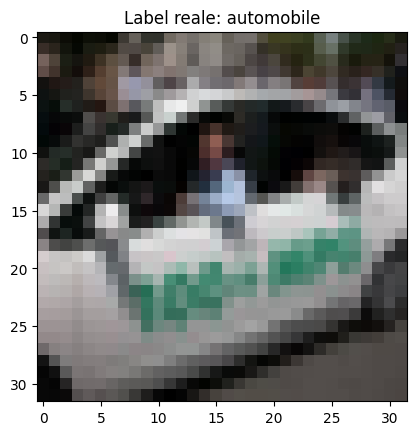

Predizione del modello: automobile


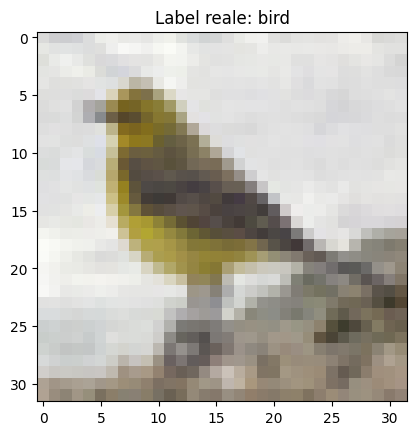

Predizione del modello: bird


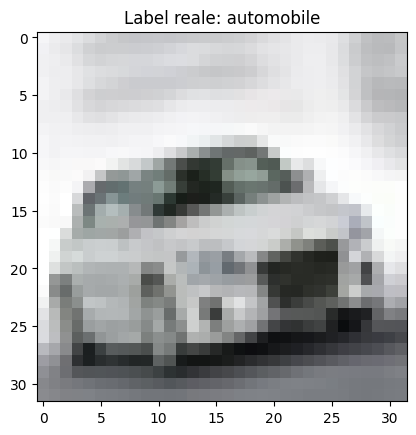

Predizione del modello: automobile


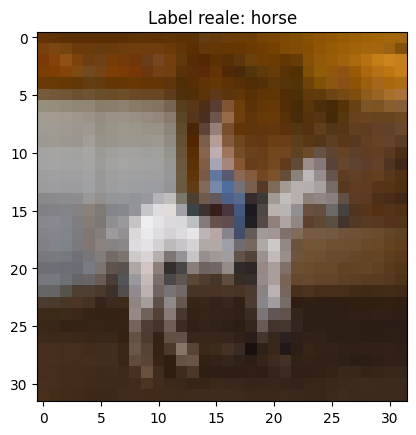

Predizione del modello: dog


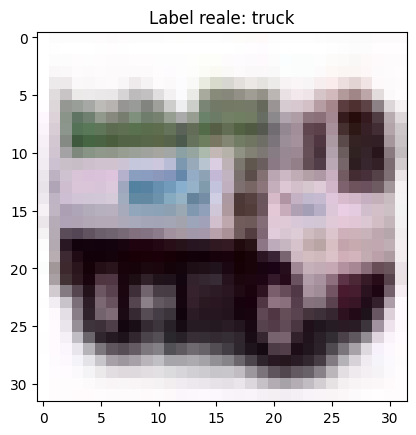

Predizione del modello: truck


In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Trasformazioni test
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Dataset di test
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Mappa delle classi CIFAR-10
classes = ('airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck')

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Variabili per calcolare accuracy
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy sul test set: {accuracy:.2f}%')

# Visualizziamo alcune immagini a caso con predizione
num_show = 5
for _ in range(num_show):
    idx = np.random.randint(0, len(testset))
    image, label = testset[idx]
    
    # Mostriamo immagine denormalizzata
    image_display = image * 0.5 + 0.5
    plt.imshow(np.transpose(image_display.numpy(), (1, 2, 0)))
    plt.title(f'Label reale: {classes[label]}')
    plt.show()
    
    # Predizione
    input_img = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_img)
        _, predicted = torch.max(output, 1)
    print(f'Predizione del modello: {classes[predicted.item()]}')


In [3]:
# dopo il training
torch.save(model.state_dict(), "quaternion_cnn.pth")
